In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
file_path = Path("visa.csv")
visa = pd.read_csv(file_path)

#"case_status"
visa.loc[visa.case_status=="Certified", "case_status"]=1
visa.loc[visa.case_status=="Denied", "case_status"]=0
visa["case_status"]=visa["case_status"].astype(str).astype(int)


visa.head()

,Unnamed: 0,application_type,case_received_year,case_status,class_of_admission,decision_year,employer_country,employer_name,employer_num_employees,employer_state,...,job_info_experience,job_info_foreign_ed,job_info_foreign_lang_req,job_info_job_title,job_info_training,pw_amount_9089,pw_job_title_9089,pw_level_9089,pw_source_name_9089,pw_unit_of_pay_9089
0,0,PERM,2014,1,J-1,1328054400000000000,NaN,NETSOFT USA INC.,22348,NY,...,Y,Y,N,NaN,N,75629.0,"Computer Software Engineers, Applications",Level II,OES,Year
1,1,PERM,2014,0,B-2,1324425600000000000,NaN,PINNACLE ENVIRONEMNTAL CORP,22348,NY,...,Y,Y,N,NaN,N,37024.0,ASBESTOS HANDLER,Level I,OES,Year
2,2,PERM,2014,1,H-1B,1322697600000000000,NaN,"SCHNABEL ENGINEERING, INC.",22348,VA,...,Y,Y,N,NaN,N,47923.0,Civil Engineer,Level I,OES,Year
3,3,PERM,2014,1,B-2,1322697600000000000,NaN,EBENEZER MISSION CHURCH,22348,NY,...,Y,Y,N,NaN,N,21940.0,File Clerk,Level II,OES,Year
4,4,PERM,2014,1,L-1,1327536000000000000,NaN,ALBANY INTERNATIONAL CORP.,22348,NY,...,Y,Y,N,NaN,N,94890.0,Sales & Service Engineer,Level IV,OES,Year


### Convert categorical features to dummy variables 

In [4]:
application_type = pd.get_dummies(visa["application_type"],drop_first=True)
class_of_admission = pd.get_dummies(visa["class_of_admission"],drop_first=True)
foreign_worker_info_education = pd.get_dummies(visa["foreign_worker_info_education"],drop_first=True)
country_of_citizenship = pd.get_dummies(visa["country_of_citizenship"],drop_first=True)
fw_info_rel_occup_exp = pd.get_dummies(visa["fw_info_rel_occup_exp"],drop_first=True)
fw_info_req_experience = pd.get_dummies(visa["fw_info_req_experience"],drop_first=True)
job_info_education = pd.get_dummies(visa["job_info_education"],drop_first=True)
job_info_experience = pd.get_dummies(visa["job_info_experience"],drop_first=True)
job_info_training = pd.get_dummies(visa["job_info_training"],drop_first=True)

In [6]:
visa.drop(["application_type","class_of_admission","foreign_worker_info_education","country_of_citizenship",
          "fw_info_rel_occup_exp","fw_info_req_experience","job_info_education","job_info_experience",
          "job_info_training","pw_level_9089","employer_country","employer_name","employer_state",
          "foreign_worker_info_major","foreign_worker_info_state","fw_info_alt_edu_experience","fw_info_birth_country",
          "job_info_foreign_ed","job_info_foreign_lang_req","job_info_job_title","pw_job_title_9089","pw_source_name_9089",
          "pw_unit_of_pay_9089"],axis=1,inplace=True)

In [7]:
visa=pd.concat([visa,application_type,class_of_admission,foreign_worker_info_education,country_of_citizenship,
          fw_info_rel_occup_exp,fw_info_req_experience,job_info_education,job_info_experience,
          job_info_training],axis=1)

In [8]:
visa.head()

,Unnamed: 0,case_received_year,case_status,decision_year,employer_num_employees,job_info_alt_occ_num_months,pw_amount_9089,ONLINE,PERM,A1/A2,...,N,Y,Bachelor's,Doctorate,High School,Master's,None,Other,Y,Y
0,0,2014,1,1328054400000000000,22348,60.0,75629.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,1,2014,0,1324425600000000000,22348,60.0,37024.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,2,2014,1,1322697600000000000,22348,60.0,47923.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,3,2014,1,1322697600000000000,22348,60.0,21940.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,4,2014,1,1327536000000000000,22348,60.0,94890.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


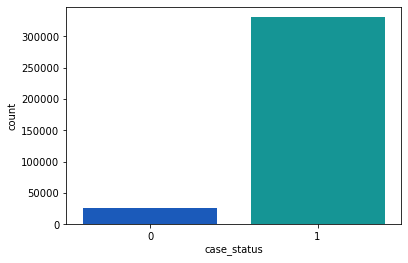

In [9]:
sns.countplot(x="case_status",data=visa, palette="winter")

In [10]:
y = visa["case_status"]
X = visa.drop(columns="case_status")

In [11]:
X.describe()

,Unnamed: 0,case_received_year,decision_year,employer_num_employees,job_info_alt_occ_num_months,pw_amount_9089,ONLINE,PERM,A1/A2,AOS,...,N,Y,Bachelor's,Doctorate,High School,Master's,None,Other,Y,Y
count,356168.000000,356168.000000,3.561680e+05,3.561680e+05,356168.000000,3.561680e+05,356168.000000,356168.00000,356168.000000,356168.000000,...,356168.000000,356168.000000,356168.000000,356168.000000,356168.000000,356168.000000,356168.000000,356168.000000,356168.000000,356168.000000
mean,187824.581953,2014.561990,1.423923e+18,2.234837e+04,50.612947,4.696245e+05,0.940388,0.05396,0.000418,0.000003,...,0.102606,0.128234,0.249315,0.021661,0.009439,0.635975,0.058371,0.020729,0.717833,0.011938
std,108551.954744,0.892878,4.244757e+16,6.699144e+04,18.721351,7.679620e+06,0.236767,0.22594,0.020449,0.001676,...,0.303444,0.334351,0.432617,0.145575,0.096697,0.481156,0.234445,0.142476,0.450055,0.108608
min,0.000000,2006.000000,1.317600e+18,0.000000e+00,0.000000,7.500000e+00,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93461.750000,2014.000000,1.396483e+18,3.510000e+02,36.000000,6.780800e+04,1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,188083.500000,2014.000000,1.432685e+18,2.234800e+04,60.000000,8.627800e+04,1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,282299.250000,2015.000000,1.458778e+18,2.234800e+04,60.000000,1.047900e+05,1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,374353.000000,2016.000000,1.483056e+18,1.633332e+07,240.000000,4.957480e+08,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Check the balance of our target values
y.value_counts()

1    330519
0     25649
Name: case_status, dtype: int64

### Test-Train-Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1, stratify=y)

X_train.shape

(267126, 282)

In [14]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(X_train.values, y_train.values)
Counter(y_res)

Counter({1: 247889, 0: 247889})

In [15]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(random_state=1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

In [16]:
#from random_forest.fit(X_train,y_train.ravel())
#y_pred.summary()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [17]:
y_pred = logreg.predict(X_test)
print('log: ', metrics.accuracy_score(y_test, y_pred))

log:  0.07201096111947171


In [18]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5

In [19]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 6412,     0],
       [82630,     0]])

In [20]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      1.00      0.00      0.13      0.00      0.00      6412
          1       0.00      0.00      1.00      0.00      0.00      0.00     82630

avg / total       0.01      0.07      0.93      0.01      0.00      0.00     89042



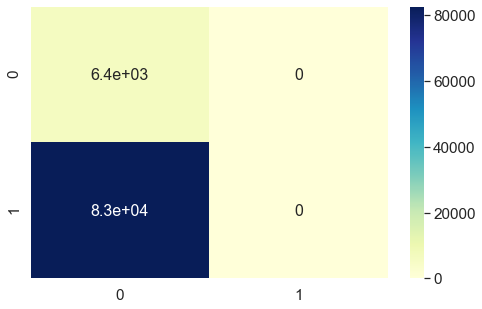

In [21]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size

### SMOTE Oversampling

In [22]:
# Resample the training data with SMOTE
X_res, y_res = SMOTE(random_state=1).fit_resample(X_train.values, y_train.values)
Counter(y_res)

Counter({1: 247889, 0: 247889})

In [23]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(random_state=1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

In [24]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5

In [25]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[    0,  6412],
       [    0, 82630]])

In [26]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00      6412
          1       0.93      1.00      0.00      0.96      0.00      0.00     82630

avg / total       0.86      0.93      0.07      0.89      0.00      0.00     89042



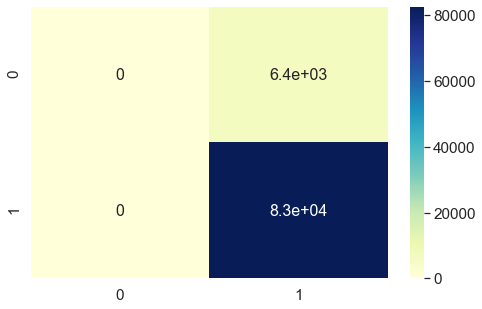

In [27]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size

## Ensemble Learners
### Balanced Random Forest Classifier

In [28]:
# Resample the training data with the BalancedRandomForestClassifier
random_forest_model = BalancedRandomForestClassifier(random_state=1)
random_forest_model = random_forest_model.fit(X_train.values, y_train.values)
y_pred = random_forest_model.predict(X_test)

In [29]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8824762983359971

In [30]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 5608,   804],
       [ 9061, 73569]])

In [31]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.38      0.87      0.89      0.53      0.88      0.78      6412
          1       0.99      0.89      0.87      0.94      0.88      0.78     82630

avg / total       0.95      0.89      0.88      0.91      0.88      0.78     89042



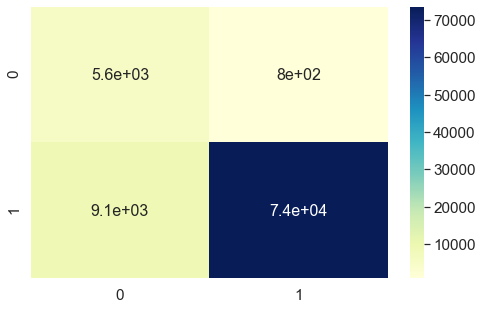

In [32]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size